<a href="https://colab.research.google.com/github/ailsonramon/timeseries/blob/main/TS_spain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introdução

1 - Pre-processamento dos dados
    
    importação
    limpeza
    formatacao
    treino e test
2 - Análise Exploratória dos dados
    
    resumo estatístico
    grafico de linha
    graficos boxplot
    Tendencia e Sazonalidades
3 - Transformações

    Transformações Ln
    Transformação boxcox
4 - Decomposição

    Aditiva
    Multiplicativa
5  - Previsões (forescasting)

    Naive
    ExponentialSmoothing
    ARIMA

    

#1. Pre-processamento

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.stats as stats
import scipy.special as special 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
#from arch.unitroot import PhillipsPerron
#from sklearn.metrics import mean_absolute_percentage_error
from pandas import concat
from pandas import Series
#sets the maximum number of rows and columns displayed when a frame is pretty-printed.
pd.set_option("max_columns",20)
#graphs will be included in your notebook
%matplotlib inline
#figure formate
%config InlineBackend.figure_format = "svg"

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
url_train = "https://raw.githubusercontent.com/ailsonramon/timeseries/main/hourly_20140102_20191101_train.csv"
url_test = "https://raw.githubusercontent.com/ailsonramon/timeseries/main/hourly_20140102_20191101_test.csv"
col_list = ["datetime","value"]
df = pd.read_csv(url_train, usecols=col_list, parse_dates=[1])
test = pd.read_csv(url_test, usecols=col_list, parse_dates=[1])
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245376 entries, 0 to 245375
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   value     245376 non-null  int64 
 1   datetime  245376 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.7+ MB


,value,datetime
0,24256,2014-01-02 00:00:00+01:00
1,24260,2014-01-02 00:10:00+01:00
2,23689,2014-01-02 00:20:00+01:00
3,23349,2014-01-02 00:30:00+01:00
4,22896,2014-01-02 00:40:00+01:00


In [40]:
#Select a percentage from the time series
data_proportion = lambda serie, percent=1.0: serie[-int(percent * len(serie)):]

In [49]:
df = df.dropna()
df.datetime = pd.to_datetime(df.datetime, utc=True)
df.set_index("datetime", inplace=True)
test = test.dropna()
test.datetime = pd.to_datetime(test.datetime, utc=True)
test.set_index("datetime", inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 245376 entries, 2014-01-01 23:00:00+00:00 to 2018-09-01 22:50:00+00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   value   245376 non-null  int64
dtypes: int64(1)
memory usage: 3.7 MB


In [5]:
df.head()

,value
datetime,
2014-01-01 23:00:00+00:00,24256
2014-01-01 23:10:00+00:00,24260
2014-01-01 23:20:00+00:00,23689
2014-01-01 23:30:00+00:00,23349
2014-01-01 23:40:00+00:00,22896


In [6]:
df.describe()

,value
count,245376.000000
mean,28505.403230
std,4596.955053
min,17714.000000
25%,24593.000000
50%,28720.000000
75%,31997.000000
max,41217.000000


##Estruturando os dados

In [7]:
df["hour"] = df.index.hour
df["month"] = df.index.month
df["year"] = df.index.year
df["week"] = [d.strftime('%a') for d in df.index]
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 245376 entries, 2014-01-01 23:00:00+00:00 to 2018-09-01 22:50:00+00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   value   245376 non-null  int64 
 1   hour    245376 non-null  int64 
 2   month   245376 non-null  int64 
 3   year    245376 non-null  int64 
 4   week    245376 non-null  object
dtypes: int64(4), object(1)
memory usage: 11.2+ MB


,value,hour,month,year,week
datetime,,,,,
2014-01-01 23:00:00+00:00,24256,23,1,2014,Wed
2014-01-01 23:10:00+00:00,24260,23,1,2014,Wed
2014-01-01 23:20:00+00:00,23689,23,1,2014,Wed
2014-01-01 23:30:00+00:00,23349,23,1,2014,Wed
2014-01-01 23:40:00+00:00,22896,23,1,2014,Wed


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 245376 entries, 2014-01-01 23:00:00+00:00 to 2018-09-01 22:50:00+00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   value   245376 non-null  int64 
 1   hour    245376 non-null  int64 
 2   month   245376 non-null  int64 
 3   year    245376 non-null  int64 
 4   week    245376 non-null  object
dtypes: int64(4), object(1)
memory usage: 11.2+ MB


In [9]:
def split_train_test(serie, percent=0.75):
  train_size = int(len(serie) * percent)
  train = serie[1:train_size]
  test = serie[train_size:]
  return train, test

df, df_test = split_train_test(df)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 184031 entries, 2014-01-01 23:10:00+00:00 to 2017-07-02 22:50:00+00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   value   184031 non-null  int64 
 1   hour    184031 non-null  int64 
 2   month   184031 non-null  int64 
 3   year    184031 non-null  int64 
 4   week    184031 non-null  object
dtypes: int64(4), object(1)
memory usage: 8.4+ MB


#2. Análise Exploratória

##Resumo Estatístico

In [10]:
df["value"].describe()

count    184031.000000
mean      28275.831501
std        4563.208181
min       17714.000000
25%       24347.000000
50%       28531.000000
75%       31733.000000
max       41217.000000
Name: value, dtype: float64

In [11]:
def stat_summary(timeserie):
  X = timeserie["value"]
  split = len(X) // 2
  X1, X2 = X[0:split], X[split:]
  mean1, mean2 = X1.mean(), X2.mean()  
  var1, var2 = X1.var(), X2.var()
  print("Media da primeira parte: %f, \nMedia da segunda parte:%f" %(mean1, mean2))
  #print(f"variancia1:{var1} \nvariancia2:{var2}")
  print("Variancia1:%f\nVariancia2:%f" % (var1,var2))

stat_summary(df)

Media da primeira parte: 28154.084867, 
Media da segunda parte:28397.576813
Variancia1:21202413.042497
Variancia2:20413910.857264


Tanto a média quando a variância nas duas partes da série não apresentam uma grande variação. 

##Análise Gráfica

###Gráfico de linha

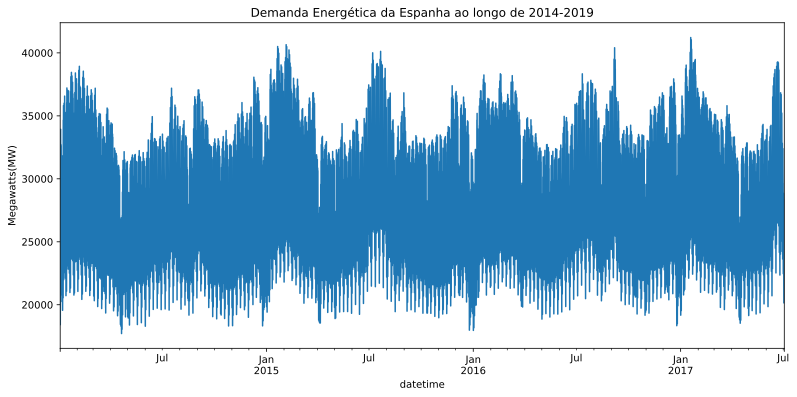

In [12]:
df["value"].plot(figsize=(13,6))
plt.title("Demanda Energética da Espanha ao longo de 2014-2019")
plt.ylabel("Megawatts(MW)")
plt.show()

###Histograma

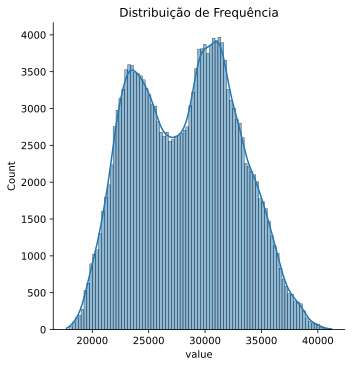

In [13]:
sns.displot(data=df, kde=True, x="value")
plt.title("Distribuição de Frequência")
plt.show()

###Análise Anual

####Gráfico de Linha

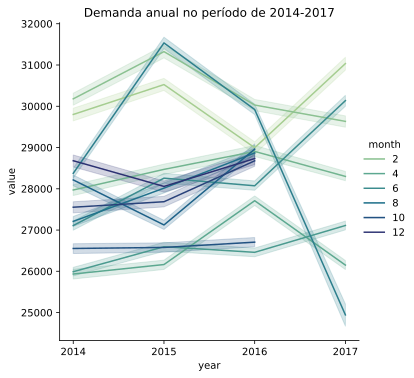

In [14]:
sns.relplot(data=df, x="year", y="value", hue="month", kind="line", palette="crest")
plt.xticks(np.arange(2014,2018,1))
plt.title("Demanda anual no período de 2014-2017")
plt.show()

####Boxplot

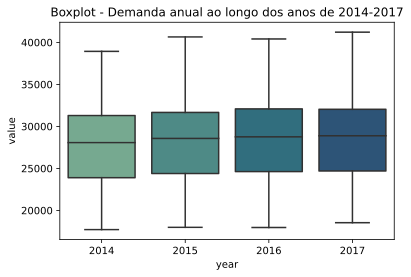

In [15]:
sns.boxplot(data=df, x="year", y="value", palette="crest")
plt.title("Boxplot - Demanda anual ao longo dos anos de 2014-2017")
plt.show()

###Análise mensal

####Gráfico de Linha

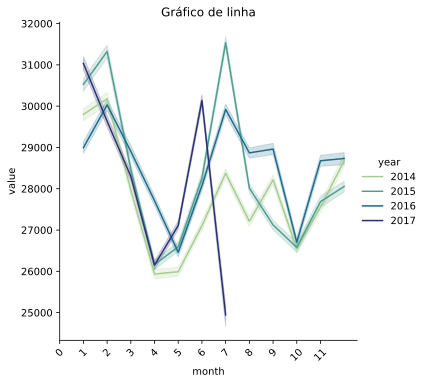

In [16]:
sns.relplot(data=df, x="month", hue="year", y="value", kind="line", palette="crest")
plt.xticks(np.arange(0,12,1), rotation=45)
plt.title("Gráfico de linha")
plt.show()

####Barras

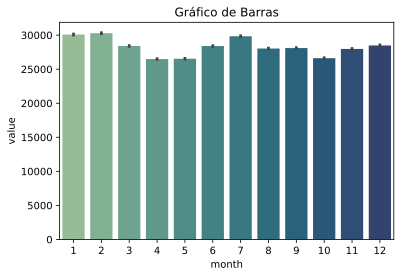

In [17]:
sns.barplot(data=df, x="month", y="value", palette="crest")
plt.title("Gráfico de Barras")
plt.show()

####Boxplot

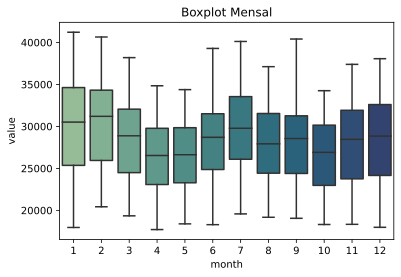

In [18]:
sns.boxplot(data=df, x="month", y="value", palette="crest")
plt.title("Boxplot Mensal")
plt.show()

###Análise semanal

####Gráfico de linha

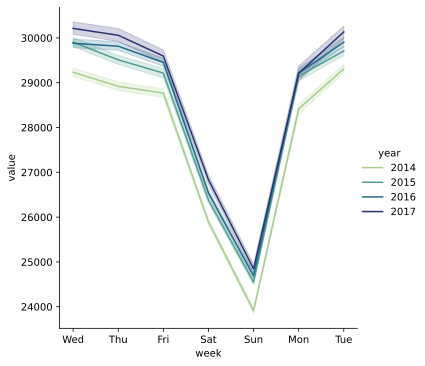

In [19]:
sns.relplot(data=df, x="week", y = "value", hue="year", kind="line", palette="crest");

####Boxplot

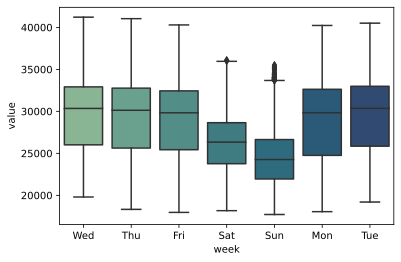

In [20]:
sns.boxplot(data=df, x="week", y="value", palette="crest");

###Análise diária

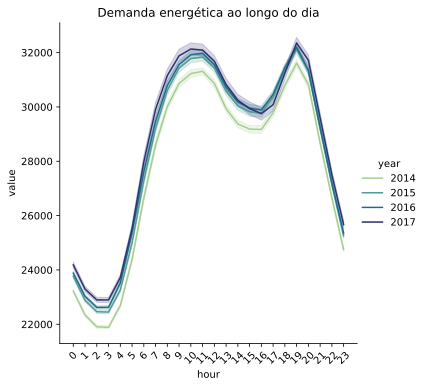

In [21]:
sns.relplot(data=df, x="hour", y="value",hue="year", kind="line", palette="crest")
plt.xticks(np.arange(0,24,1), rotation=45)
plt.title("Demanda energética ao longo do dia")
plt.show()

#3. Transformações

In [22]:
def plot_mean_std(timeseries):
  #Determing rolling statistics
  rolmean = timeseries.rolling(window=365*24*6).mean()
  rolstd = timeseries.rolling(window=365*24*6).std()
  #Plot rolling statistics:
  orig = plt.plot(timeseries, color='blue',label='Original')
  mean = plt.plot(rolmean, color='red', label='Rolling Mean')
  std = plt.plot(rolstd, color='black', label = 'Rolling Std')
  plt.legend(loc='best')
  plt.plot(figsize=(12,6))
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block=False)

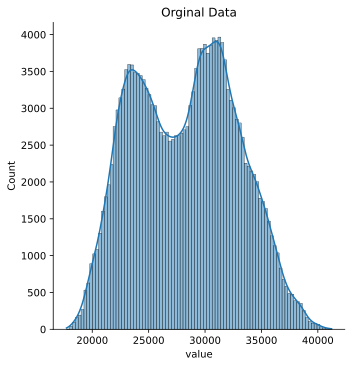

In [23]:
sns.displot(df.value, kde=True)
plt.title("Orginal Data")
plt.show()

##Logaritma

In [24]:
df_log = np.log(df.value)

####Grafico de linha

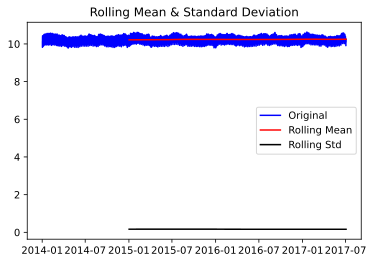

In [25]:
#df_log.plot()
plot_mean_std(df_log)
#plt.title("Transformação ln")
#plt.show()

####Histrograma

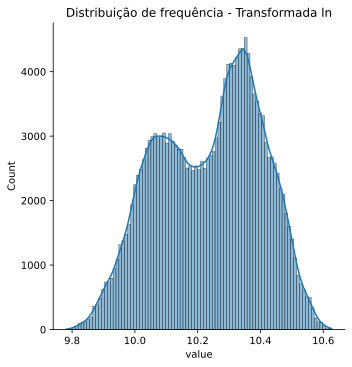

In [26]:
sns.displot(df_log, kde=True)
plt.title("Distribuição de frequência - Transformada ln")
plt.show()

##Boxcox

In [27]:
from scipy import stats
fitted_data, fitted_lambda = stats.boxcox(df.value)

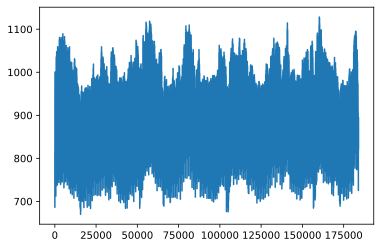

In [28]:
plt.plot(fitted_data);

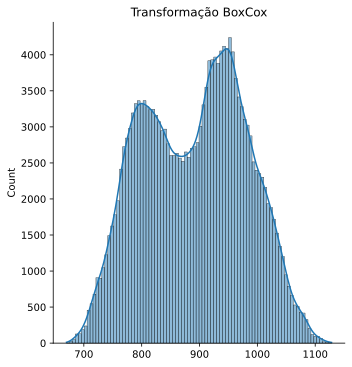

Lambda value used for Tranformation: 0.6159303756491706


In [29]:
sns.displot(fitted_data, kde=True)
plt.title("Transformação BoxCox")
plt.show()
print(f"Lambda value used for Tranformation: {fitted_lambda}")

##Média movel

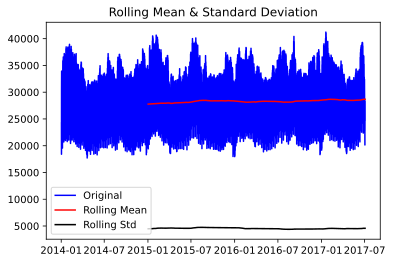

In [30]:
plot_mean_std(df.value)

#4. Decomposiçoes

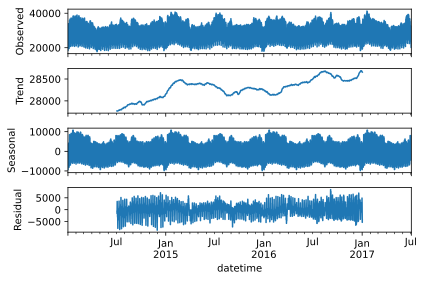

In [31]:
additive_decompose = seasonal_decompose(df.value, model="additive", freq=365*24*6)
additive_decompose.plot()
plt.show()

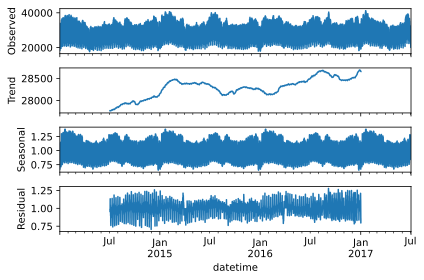

In [32]:
mult_decomp = seasonal_decompose(df.value, model="multiplicative", freq=365*24*6)
mult_decomp.plot()
plt.show()

# 5. Previsões

##ARIMA

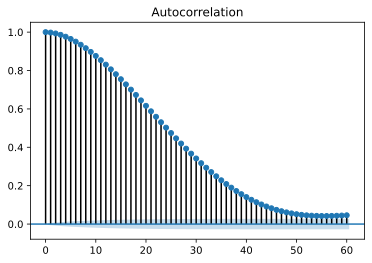

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df.value, lags=60)
plt.show()

Ao analisar o gráfico de auto correlação gerado acima acredita-se que todos os lags poderiam ser usados para criar previsões para eventos futuros, pois todos tem uma correlação positiva próximo de 1 e estão fora do intervalo de confiança, porém essa característica de auto correlação é de uma série não estacionária.

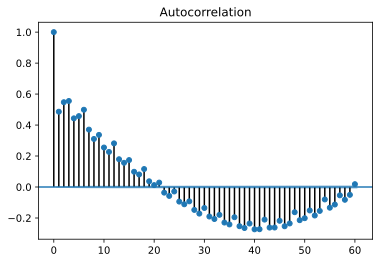

In [34]:
plot_acf(df['value'].diff().dropna(), lags=60)
plt.show()

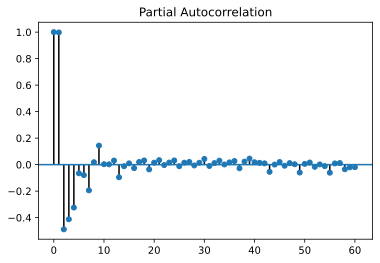

In [35]:
plot_pacf(df.value, lags=60)
plt.show()

In [52]:
train = df.resample("10T").last()
test = test.resample("10T").last()

In [39]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train.value.fillna(0), freq="10T", order=(2,1,2)).fit()
model.params

const            0.002782
ar.L1.D.value    1.428468
ar.L2.D.value   -0.476164
ma.L1.D.value   -1.297008
ma.L2.D.value    0.538334
dtype: float64

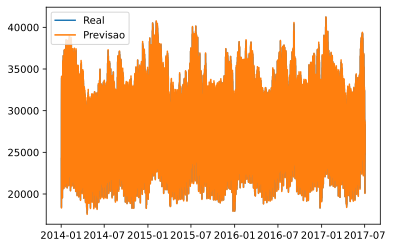

In [42]:
plt.plot(train.value)
plt.plot(model.predict(typ='levels'))
plt.legend(['Real', 'Previsao'])
plt.show()

In [50]:
model_test= ARIMA(test.value.fillna(0), freq="10T", order=(2,1,2)).fit(model.params)
(model_test.resid ** 2).mean()

53315.2114026366

In [54]:
test

,value
datetime,
2018-09-01 23:00:00+00:00,25392
2018-09-01 23:10:00+00:00,25302
2018-09-01 23:20:00+00:00,25122
2018-09-01 23:30:00+00:00,24627
2018-09-01 23:40:00+00:00,24488
...,...
2019-11-01 22:00:00+00:00,24628
2019-11-01 22:10:00+00:00,24440
2019-11-01 22:20:00+00:00,24073


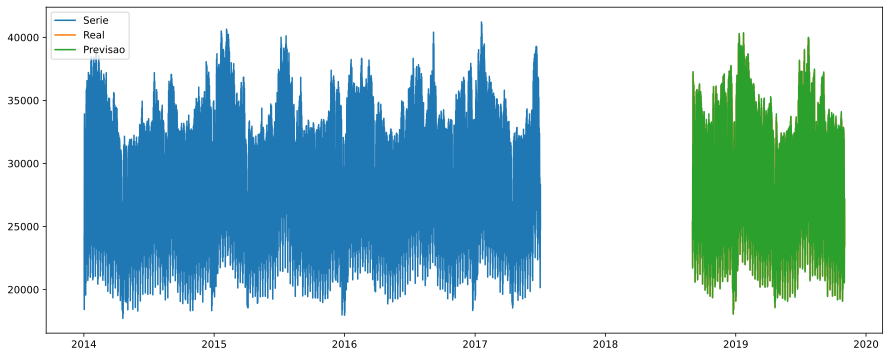

In [56]:
plt.figure(figsize=(15,6))
plt.plot(df.value)
plt.plot(test.value)
plt.plot(model_test.predict(typ='levels'))
plt.legend(['Serie', 'Real', 'Previsao'])
plt.show()

#Avaliação do Modelo

In [57]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_error

def check_erro(orig, prev, nome_col='', nome_indice=''):    
    vies = np.mean(orig - prev)
    mse = mean_squared_error(orig, prev)
    rmse = sqrt(mean_squared_error(orig, prev))
    mae = mean_absolute_error(orig, prev)
    mape = np.mean(np.abs((orig - prev) / orig)) * 100    
    grupo_erro = [vies, mse, rmse, mae, mape]
    serie = pd.DataFrame(grupo_erro, index=['VIÉS','MSE','RMSE','MAE', 'MAPE'], columns=[nome_col])
    serie.index.name = nome_indice    
    return serie

In [60]:
configs = [(1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 1, 3), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 1, 3), (3, 1, 0), (3, 1, 1), (3,1, 2), (3, 1, 3)]
best = 53315
for config in configs:
  arima = ARIMA(train.value.fillna(0), freq="10T", order=config).fit()
  arima_test = ARIMA(test.value.fillna(0), freq='10T', order=config).fit(arima.params)
  erro = (arima_test.resid ** 2).mean()
  print(f"Config:{config} - MSE {erro}")
  if erro < best:
    erro_treino = check_erro(test.value[1:], arima_test.predict(typ='levels'), nome_col='Simples', nome_indice='Base Treino')
    print(f"Melhor resultado: config:{config} - MSE: {erro}")
    print(erro_treino)


Config:(1, 1, 0) - MSE 73737.02573251571
Melhor resultado: config:(1, 1, 0) - MSE: 73737.02573251571
                  Simples
Base Treino              
VIÉS            -0.022497
MSE          73737.025733
RMSE           271.545624
MAE            210.267008
MAPE             0.759011
Config:(1, 1, 1) - MSE 56614.22304576509
Melhor resultado: config:(1, 1, 1) - MSE: 56614.22304576509
                  Simples
Base Treino              
VIÉS            -0.016774
MSE          56614.223046
RMSE           237.937435
MAE            182.892546
MAPE             0.657950
Config:(1, 1, 2) - MSE 53599.85400283442
Melhor resultado: config:(1, 1, 2) - MSE: 53599.85400283442
                  Simples
Base Treino              
VIÉS            -0.016908
MSE          53599.854003
RMSE           231.516423
MAE            176.832964
MAPE             0.634966
Config:(1, 1, 3) - MSE 53534.20359965055
Melhor resultado: config:(1, 1, 3) - MSE: 53534.20359965055
                  Simples
Base Treino             